In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense,Dropout,Flatten
from keras.layers import Activation,MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.utils.np_utils import to_categorical

import cv2
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_dir='images/train'
test_dir='images/test'
eval_dir='images/eval'

In [19]:
#classes: Optional list of class subdirectories (e.g. ['dogs', 'cats'])
train_batch_gen=ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest').flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=64,
    classes=['cat','dog'])

test_batch_gen=ImageDataGenerator(rescale=1./255.).flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=64,
    classes=['cat','dog'],shuffle=False)  


eval_batch_gen=ImageDataGenerator(rescale=1./255.).flow_from_directory(
    eval_dir,
    target_size=(224,224),
    batch_size=64,
    classes=['cat','dog']) #can also do class_mode='binary' # seems by putting cat first is consider that [1,0] and dog is [0,1]


Found 4778 images belonging to 2 classes.
Found 370 images belonging to 2 classes.
Found 376 images belonging to 2 classes.


In [4]:
len(eval_batch_gen.filenames) 

376

In [5]:
eval_batch_gen.samples

376

In [6]:
def visualize(img,ax):
    #img=cv2.imread(path)
    ax.imshow(img)

In [7]:
imgs,labels=next(train_batch_gen)
print(len(labels))

64


In [8]:
labels[0]

array([ 0.,  1.], dtype=float32)

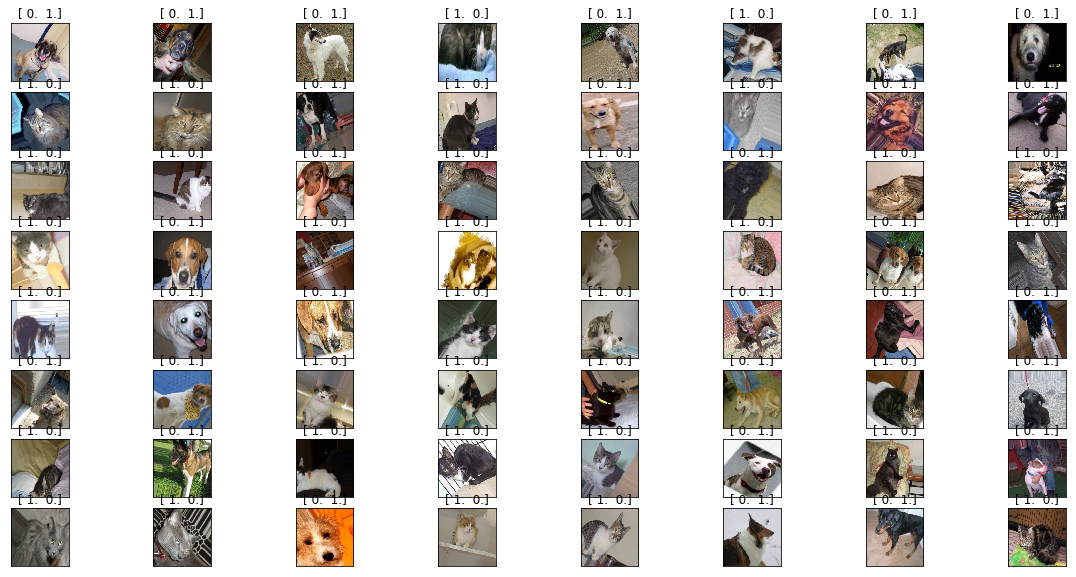

In [9]:
plt.figure(figsize=(20,10))
for i in range(len(labels)):
    ax=plt.subplot(8,len(labels)//8,i+1,xticks=[],yticks=[])
    visualize(imgs[i],ax)
    ax.set_title(labels[i])

# Building CNN

In [10]:
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)), #stride default (1,1), padding default='valid'
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(100,activation='relu'), #(224-3)/1 +1= > 222*222*32 => 222*222*32
    Dropout(0.5),
    Dense(2,activation='softmax')   
])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9331300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

In [12]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
#70 sample size, 10 batch size, 7 times to go through a train data in one epoch
history=model.fit_generator(train_batch_gen,epochs=5,steps_per_epoch=train_batch_gen.samples//64,
                    validation_data=eval_batch_gen,validation_steps=eval_batch_gen.samples//64,verbose=2)

Epoch 1/5
 - 56s - loss: 0.6973 - acc: 0.5264 - val_loss: 0.6737 - val_acc: 0.5638
Epoch 2/5
 - 58s - loss: 0.6741 - acc: 0.5635 - val_loss: 0.6556 - val_acc: 0.6037
Epoch 3/5
 - 56s - loss: 0.6631 - acc: 0.5828 - val_loss: 0.6418 - val_acc: 0.6037
Epoch 4/5
 - 57s - loss: 0.6522 - acc: 0.6075 - val_loss: 0.6439 - val_acc: 0.6170
Epoch 5/5
 - 57s - loss: 0.6420 - acc: 0.6270 - val_loss: 0.6149 - val_acc: 0.6569


In [14]:
history_dic=history.history

In [15]:
history_dic

{'acc': [0.52672889268544953,
  0.56385235470080708,
  0.58294442084870401,
  0.60776410689028226,
  0.62770470938897005],
 'loss': [0.69692084503011986,
  0.67394743845227112,
  0.66302037901629518,
  0.65233359477962027,
  0.64178406951990885],
 'val_acc': [0.56382978469767464,
  0.60372340045076733,
  0.60372340552350312,
  0.61702127913211258,
  0.65691489361702127],
 'val_loss': [0.67365358357733873,
  0.65561581672506131,
  0.641793744361147,
  0.64393062667643775,
  0.61487927208555504]}

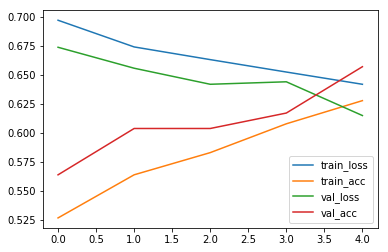

In [17]:
import matplotlib.pyplot as plt
list_epoch=np.arange(0,5)
plt.plot(list_epoch,history_dic['loss'])
plt.plot(list_epoch,history_dic['acc'])
plt.plot(list_epoch,history_dic['val_loss'])
plt.plot(list_epoch,history_dic['val_acc'])
plt.legend(['train_loss','train_acc','val_loss','val_acc'])

In [18]:
test_imgs,test_labels=next(test_batch_gen)

In [19]:
test_labels

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,

In [20]:
prediction=model.predict_generator(test_batch_gen,steps=1,verbose=0)  #take two steps to go though all test

In [21]:
prediction

array([[ 0.62292314,  0.37707683],
       [ 0.59905303,  0.40094692],
       [ 0.65374625,  0.34625378],
       [ 0.57710499,  0.42289501],
       [ 0.61874634,  0.3812536 ],
       [ 0.1455382 ,  0.85446185],
       [ 0.11170859,  0.88829136],
       [ 0.50278252,  0.49721745],
       [ 0.62571734,  0.37428263],
       [ 0.66618395,  0.33381602],
       [ 0.24249779,  0.7575022 ],
       [ 0.5988003 ,  0.40119973],
       [ 0.6210559 ,  0.37894407],
       [ 0.53482419,  0.46517581],
       [ 0.37452611,  0.62547386],
       [ 0.55135989,  0.44864008],
       [ 0.56176847,  0.4382315 ],
       [ 0.52746648,  0.47253352],
       [ 0.42604625,  0.57395375],
       [ 0.64524341,  0.35475662],
       [ 0.67936116,  0.32063884],
       [ 0.59530795,  0.40469208],
       [ 0.02760197,  0.9723981 ],
       [ 0.58669835,  0.41330171],
       [ 0.60774857,  0.39225143],
       [ 0.55206722,  0.44793281],
       [ 0.64951062,  0.35048932],
       [ 0.54069161,  0.45930836],
       [ 0.60558057,

In [22]:
test_labels

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,

In [23]:
prediction_round=np.argmax(prediction,axis=1)
test_round=np.argmax(test_labels,axis=1)


In [24]:
np.mean(prediction_round==test_round)

0.625

In [25]:
cm=confusion_matrix(prediction_round,test_round)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[28 21]
 [ 3 12]]


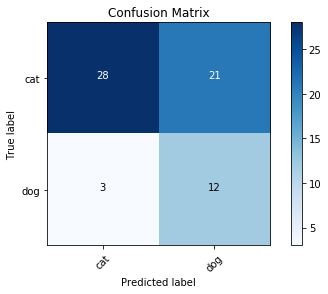

In [27]:
#if argmax=0 'cat' [1,0], if argmax=1 'dog' [0,1]
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Build and fine-tune VGG16


In [52]:
#another way from keras.applications import VGG16
#conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3)) #input shape optional, drop FC
model_vgg16=keras.applications.vgg16.VGG16(weights='imagenet')

In [5]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
len(model_vgg16.trainable_weights)  #16*2 16*(wweigh+bias), count conv and fc no pooling

32

In [7]:
type(model_vgg16)  #from keras functional API

keras.engine.training.Model

In [8]:
model=Sequential()

for layer in model_vgg16.layers[:-1]:  #this will drop the last layer prediction (Dense)
    
    model.add(layer)
    

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [10]:
print(len(model.trainable_weights))
for layer in model.layers:   #len(model.trainable_weights)
    
    layer.trainable=False   #if you put model.trainable=False (by mistake) if will do all lasyer, better doin layer by layer
print(len(model.trainable_weights))    #all turned off here,
#then need to add a FC (since is dog/cat) is small/similar sample only remove last FC and add new one



30
0


In [11]:
model.add(Dense(2,activation='softmax')) #does trainable need to be on manually ?
#print(len(model.trainable_weights))


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [13]:
len(model.trainable_weights)

2

In [14]:
print(model.layers[-1])

In [15]:
for layer in model.layers:
    print(layer.name,layer.trainable)

block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
fc2 False
dense_1 True


# train VGG16 fine-tune

In [53]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
from  keras.callbacks  import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1,save_best_only=True,save_weights_only=False)

# history=model.fit_generator(train_batch_gen,steps_per_epoch=70//5,epochs=20,
#                     validation_data=eval_batch_gen,validation_steps=20//5,verbose=2)  #
#70 sample size, 10 batch size, 7 times to go through a train data in one epoch

history=model.fit_generator(train_batch_gen,epochs=5,steps_per_epoch=train_batch_gen.samples//64,
                    validation_data=eval_batch_gen,validation_steps=eval_batch_gen.samples//64,verbose=2,callbacks=[checkpointer])

#is a restart run

Epoch 1/5
 - 59s - loss: 0.4887 - acc: 0.7812 - val_loss: 0.3910 - val_acc: 0.8404

Epoch 00001: val_loss improved from inf to 0.39103, saving model to model.weights.best.hdf5
Epoch 2/5
 - 59s - loss: 0.4726 - acc: 0.7925 - val_loss: 0.3756 - val_acc: 0.8431

Epoch 00002: val_loss improved from 0.39103 to 0.37561, saving model to model.weights.best.hdf5
Epoch 3/5
 - 58s - loss: 0.4596 - acc: 0.7989 - val_loss: 0.3692 - val_acc: 0.8404

Epoch 00003: val_loss improved from 0.37561 to 0.36919, saving model to model.weights.best.hdf5
Epoch 4/5
 - 58s - loss: 0.4378 - acc: 0.8148 - val_loss: 0.3466 - val_acc: 0.8564

Epoch 00004: val_loss improved from 0.36919 to 0.34659, saving model to model.weights.best.hdf5
Epoch 5/5
 - 58s - loss: 0.4369 - acc: 0.8093 - val_loss: 0.3431 - val_acc: 0.8511

Epoch 00005: val_loss improved from 0.34659 to 0.34312, saving model to model.weights.best.hdf5


In [ ]:
#model.load_weights('model.weights.best.hdf5')

In [55]:
from keras.models import load_model
model.save('whole_mod_last_vgg16_lastfc_out.h5')

#model2=load_model('whole_mod_last_vgg16_lastfc_out.h5')

In [57]:
#model2=load_model('whole_mod_last_vgg16_lastfc_out.h5')
#ValueError: You are trying to load a weight file containing 16 layers into a model with 0 layers.

#it seems can not get the whole model built even when saved whole model with fit_generator, call back weight False

In [24]:
prediction=model.predict_generator(test_batch_gen,steps=6,verbose=1)

6/6 [==============================] - 7s 1s/step


In [25]:
len(prediction)

370

In [36]:
#prediction

In [30]:
len(test_batch_gen.index_array)

370

In [34]:
test_batch_gen.classes #0 cat, 1 dog

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [38]:
test_labels_round=test_batch_gen.classes
predictions_round=np.argmax(prediction,axis=1)

In [39]:
np.mean(test_labels_round==predictions_round)

0.80540540540540539

In [41]:
test_loss,test_acc=model.evaluate_generator(test_batch_gen,steps=6)
print('test_accuracy',test_acc)   #bingo got simiar to np.mean()

test_accuracy 0.80540540605


In [42]:
eval_loss,eval_acc=model.evaluate_generator(eval_batch_gen,steps=5)
print('test_accuracy',eval_acc)

test_accuracy 0.85


In [43]:
train_loss,train_acc=model.evaluate_generator(train_batch_gen,steps=5)
print('test_accuracy',train_acc)

test_accuracy 0.80625


In [44]:
# count=0
# sum_=0.0
# #for i, (test_imgs,test_labels) in enumerate(test_batch_gen):
# for i in range(test_batch_gen.samples//64):
#     count=count+1
#     print(count)
#     test_imgs,test_labels=next(test_batch_gen)
#     prediction=model.predict(test_imgs)
#     prediction_round=np.argmax(prediction,axis=1)
#     test_round=np.argmax(test_labels,axis=1)
#     sum_=sum_+np.sum(prediction_round==test_round)
    
# print('accuracy:',sum_/count)    

In [46]:
history_dic=history.history

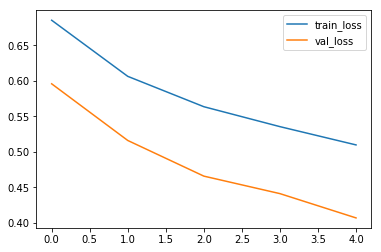

In [47]:
import matplotlib.pyplot as plt
list_epoch=np.arange(0,5)
plt.plot(list_epoch,history_dic['loss'])

plt.plot(list_epoch,history_dic['val_loss'])

plt.legend(['train_loss','val_loss'])

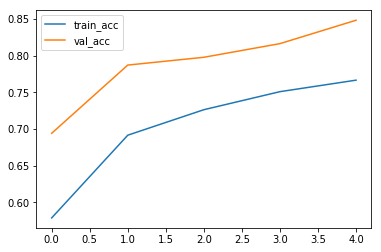

In [48]:
import matplotlib.pyplot as plt
list_epoch=np.arange(0,5)

plt.plot(list_epoch,history_dic['acc'])

plt.plot(list_epoch,history_dic['val_acc'])
plt.legend(['train_acc','val_acc'])

# Build and fine-tune VGG16  part2

In [69]:
model_vgg16_base=keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [70]:
model_vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [71]:
model_new=Sequential()

for layer in model_vgg16_base.layers:  #this will drop the last layer prediction (Dense)
    
    model_new.add(layer)

print(len(model_new.trainable_weights))
for layer in model_new.layers:   #len(model.trainable_weights)
    
    layer.trainable=False   #if you put model.trainable=False (by mistake) if will do all lasyer, better doin layer by layer
print(len(model_new.trainable_weights))    #all turned off here,
#then need to add a FC (since is dog/cat) is small/similar sample only remove last FC and add new one

    

26
0


In [72]:
model_new.add(Flatten())  #7*7*512=25088 -> original goes to 4096/4096
model_new.add(Dense(1024,activation='relu'))
model_new.add(Dropout(0.5))
model_new.add(Dense(512,activation='relu'))
model_new.add(Dropout(0.5))
model_new.add(Dense(2,activation='softmax')) #does trainable need to be on manually ?
#print(len(model.trainable_weights))


In [73]:
model_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [75]:
for layer in model_new.layers:
    print(layer.name,layer.trainable)

block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_4 True
dense_2 True
dropout_1 True
dense_3 True
dropout_2 True
dense_4 True


# train VGG16 fine-tune 2

In [76]:
model_new.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [77]:
from  keras.callbacks  import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1,save_best_only=True,save_weights_only=False)

# history=model.fit_generator(train_batch_gen,steps_per_epoch=70//5,epochs=20,
#                     validation_data=eval_batch_gen,validation_steps=20//5,verbose=2)  #
#70 sample size, 10 batch size, 7 times to go through a train data in one epoch

history=model_new.fit_generator(train_batch_gen,epochs=10,steps_per_epoch=train_batch_gen.samples//64,
                    validation_data=eval_batch_gen,validation_steps=eval_batch_gen.samples//64,verbose=2,callbacks=[checkpointer])

#is a restart run

Epoch 1/10
 - 59s - loss: 0.6970 - acc: 0.6429 - val_loss: 0.3355 - val_acc: 0.8644

Epoch 00001: val_loss improved from inf to 0.33547, saving model to model.weights.best.hdf5
Epoch 2/10
 - 58s - loss: 0.4394 - acc: 0.7924 - val_loss: 0.2663 - val_acc: 0.8883

Epoch 00002: val_loss improved from 0.33547 to 0.26628, saving model to model.weights.best.hdf5
Epoch 3/10
 - 59s - loss: 0.3730 - acc: 0.8268 - val_loss: 0.2207 - val_acc: 0.9122

Epoch 00003: val_loss improved from 0.26628 to 0.22066, saving model to model.weights.best.hdf5
Epoch 4/10
 - 59s - loss: 0.3494 - acc: 0.8418 - val_loss: 0.2114 - val_acc: 0.9096

Epoch 00004: val_loss improved from 0.22066 to 0.21138, saving model to model.weights.best.hdf5
Epoch 5/10
 - 58s - loss: 0.3189 - acc: 0.8603 - val_loss: 0.2148 - val_acc: 0.9122

Epoch 00005: val_loss did not improve from 0.21138
Epoch 6/10
 - 57s - loss: 0.3205 - acc: 0.8591 - val_loss: 0.2186 - val_acc: 0.9122

Epoch 00006: val_loss did not improve from 0.21138
Epoch 7/

In [80]:
from keras.models import load_model
model_new.save('test.h5')

#model_test=load_model('test.h5')

#You are trying to load a weight file containing 16 layers into a model with 0 layers.
#still same issue even when putting input_shape explicitly when loading vgg16 originally
#has to do we keras version

In [82]:
prediction=model_new.predict_generator(test_batch_gen,steps=6,verbose=1)
test_labels_round=test_batch_gen.classes
predictions_round=np.argmax(prediction,axis=1)
np.mean(test_labels_round==predictions_round)  #much better improvement when put new FC (3 layer with dropout)

6/6 [==============================] - 3s 573ms/step


0.89459459459459456

In [85]:
test_loss,test_acc=model.evaluate_generator(test_batch_gen,steps=6)
print('test_accuracy',test_acc)   #bingo got simiar to np.mean()
eval_loss,eval_acc=model.evaluate_generator(eval_batch_gen,steps=6)
print('eval_accuracy',eval_acc)
train_loss,train_acc=model.evaluate_generator(train_batch_gen,steps=6)
print('train_accuracy',train_acc)


test_accuracy 0.840540539252
eval_accuracy 0.851063833592
train_accuracy 0.8125


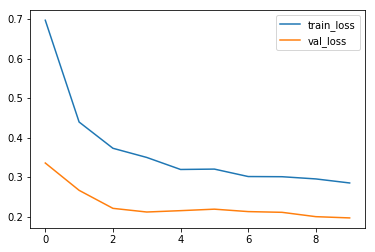

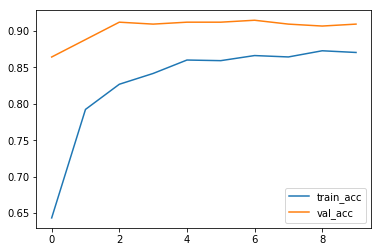

In [87]:

history_dic=history.history
import matplotlib.pyplot as plt
list_epoch=np.arange(0,10)
plt.plot(list_epoch,history_dic['loss'])

plt.plot(list_epoch,history_dic['val_loss'])

plt.legend(['train_loss','val_loss'])
plt.show()

list_epoch=np.arange(0,10)

plt.plot(list_epoch,history_dic['acc'])

plt.plot(list_epoch,history_dic['val_acc'])
plt.legend(['train_acc','val_acc'])
plt.show()

In [88]:
train_batch_gen.class_indices

{'cat': 0, 'dog': 1}